<a href="https://colab.research.google.com/github/jvallalta/ia3/blob/main/3_MLPvsRNN_1_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![IDAL](https://i.imgur.com/tIKXIG1.jpg)  

#**Máster en Inteligencia Artificial Avanzada y Aplicada:  IA^3**
---

#<strong><center>Series temporales con RNNs y MLP en KERAS</center></strong>

En este documento vamos a estudiar las posibilidades de las RNNs como modelos predictivos de series temporales. 
Las series temporales son un campo directo de aplicación de las redes recurrentes, si bien es cierto que los mejores resultados se obtienen cuando empleamos modelos más potentes como las GRUs o LSTM. 

En el ejercicio vamos a crear una red recurrente básica en TensorFlow, usando KERAS y a ver qué resultados obtiene en predicción con una serie generada artificialmente.  Además, vamos a comparar sus resultados con los de una red neuronal feedforward (no recurrente) que prepararemos (y entrenaremos) para la misma prediccion temporal. 

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.4.1


Vamos a generar la serie temporal y observar qué aspecto tiene. La serie la componemos a partir de una tendencia (*trend*) un patron estacional (*seasonal pattern*), una oscilación periodica (*seasonality*) y ruido (*noise*).

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Creamos la serie
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Le sumamos ruido
series += noise(time, noise_level, seed=42)

# Establecemos conjunto de entrenamiento y validación
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

# Parámetros para preparar las entradas al modelo
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

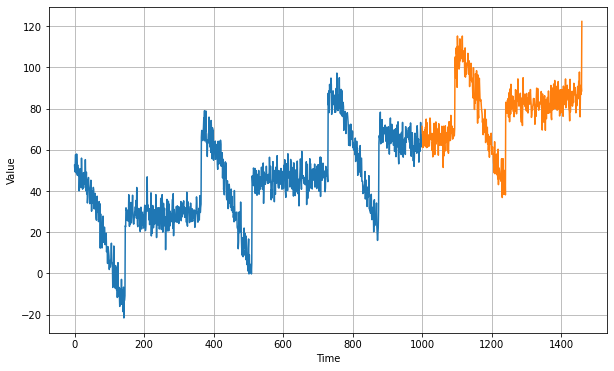

In [3]:
plt.figure(figsize=(10, 6))

plot_series(time_train, x_train)
plot_series(time_valid, x_valid)

In [4]:
print(time_train.size)
print(time_valid.size)

1000
461


En el ejemplo creado hemos especificado un periodo de 4 años (tomando como que son valores diarios) de los cuales los primeros 1000 serán el conjunto de entrenamiento y los siguientes 461 serán los valores para validar e intentar predecir

Definimos una función auxiliar para preparar los datos de entrada en bloques de tantas entradas como hayamos especificado en la ventana temporal y en los lotes correspondientes.

In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

# Modelo con RNN

Preparamos la sesion de Keras y el conjunto de entrenamiento, en entradas eventanadas y en los lotes especificados

In [6]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

Definimos el modelo en Keras

In [7]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

In [8]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, None, 40)          1680      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 40)                3240      
_________________________________________________________________
dense (Dense)                (None, 1)                 41        
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 0         
Total params: 4,961
Trainable params: 4,961
Non-trainable params: 0
_________________________________________________________________
None


Definimos una función callback para que vaya ajustando la tasa de aprendizaje y  el optimizador a emplear

In [9]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

Compilamos el modelo, dejandolo listo para entrenar

In [10]:
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

Entrenamos, guardando los resultados en `history`

In [11]:

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 3s 32ms/step - loss: 194.6263 - mae: 195.1263
Epoch 2/100
8/8 [==============================] - 0s 26ms/step - loss: 195.2580 - mae: 195.7580
Epoch 3/100
8/8 [==============================] - 0s 29ms/step - loss: 193.9793 - mae: 194.4793
Epoch 4/100
8/8 [==============================] - 0s 27ms/step - loss: 192.3059 - mae: 192.8059
Epoch 5/100
8/8 [==============================] - 0s 28ms/step - loss: 189.4673 - mae: 189.9673
Epoch 6/100
8/8 [==============================] - 0s 28ms/step - loss: 187.5114 - mae: 188.0114
Epoch 7/100
8/8 [==============================] - 0s 24ms/step - loss: 185.2977 - mae: 185.7977
Epoch 8/100
8/8 [==============================] - 0s 29ms/step - loss: 183.4114 - mae: 183.9114
Epoch 9/100
8/8 [==============================] - 0s 28ms/step - loss: 180.7796 - mae: 181.2796
Epoch 10/100
8/8 [==============================] - 0s 25ms/step - loss: 176.5626 - mae: 177.0626
Epoch 11/100
8/8 [===========

Visualizamos el error para obtener los mejores parámetros, antes de realizar un entrenamiento más a fondo. 

(1e-08, 0.0001, 0.0, 30.0)

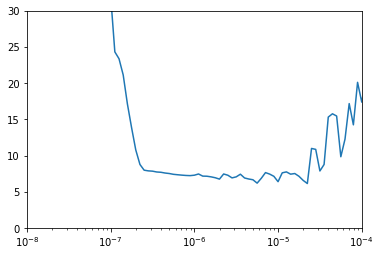

In [12]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

El error se muestra mínimo en torno a 5e-5 y con ese valor configuramos en entrenamiento final

In [13]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])
# Ajustamos con el lr obtenido por el "callback" 
optimizer = tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=100)

Epoch 1/100
8/8 [==============================] - 1s 28ms/step - loss: 114.4029 - mae: 114.9029
Epoch 2/100
8/8 [==============================] - 0s 30ms/step - loss: 22.2723 - mae: 22.7646
Epoch 3/100
8/8 [==============================] - 0s 28ms/step - loss: 17.3886 - mae: 17.8839
Epoch 4/100
8/8 [==============================] - 0s 27ms/step - loss: 13.2057 - mae: 13.7009
Epoch 5/100
8/8 [==============================] - 0s 25ms/step - loss: 9.7381 - mae: 10.2275
Epoch 6/100
8/8 [==============================] - 0s 27ms/step - loss: 15.2238 - mae: 15.7180
Epoch 7/100
8/8 [==============================] - 0s 26ms/step - loss: 14.3601 - mae: 14.8534
Epoch 8/100
8/8 [==============================] - 0s 27ms/step - loss: 10.9253 - mae: 11.4169
Epoch 9/100
8/8 [==============================] - 0s 28ms/step - loss: 10.0978 - mae: 10.5899
Epoch 10/100
8/8 [==============================] - 0s 28ms/step - loss: 9.6182 - mae: 10.1133
Epoch 11/100
8/8 [==============================]

Vamos ahora a realizar predicciones y directamente dibujamos el valor real (azul)  y el obtenido por nuestro modelo (naranja)

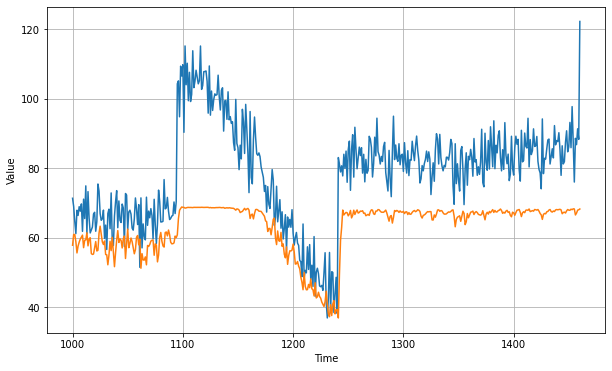

In [14]:
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

Obtenemos valor numérico de error para tener datos objetivos y comparables.

In [15]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

15.655983

Vamos a plotear el error y la métrica de salida MAE para ver su relación. Los valores los tenemos en la lista `history[ ]`

<Figure size 432x288 with 0 Axes>

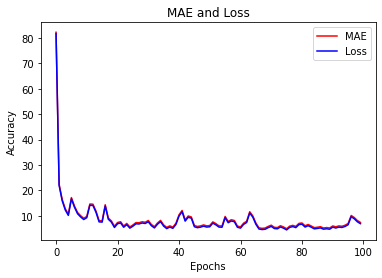

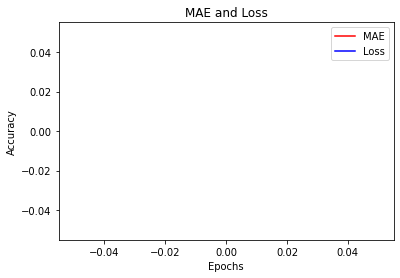

<Figure size 432x288 with 0 Axes>

In [16]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Recuperamos las listas de resultados de pérdida y error en el entrenamiento
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Ploteamos
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Ploteamos con Zoom el MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

# Modelo con MLP (*MultiLayer Perceptron*)

Vamos a definir ahora una red neuronal multicapa de "similares" caracteristicas, al menos en cuanto a nº de neuronas y capas

In [18]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(40, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(40, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model2.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
history2 = model2.fit(dataset,epochs=400,verbose=0)

In [19]:
print(model2.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_5 (Dense)              (None, 40)                1640      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 41        
Total params: 2,521
Trainable params: 2,521
Non-trainable params: 0
_________________________________________________________________
None


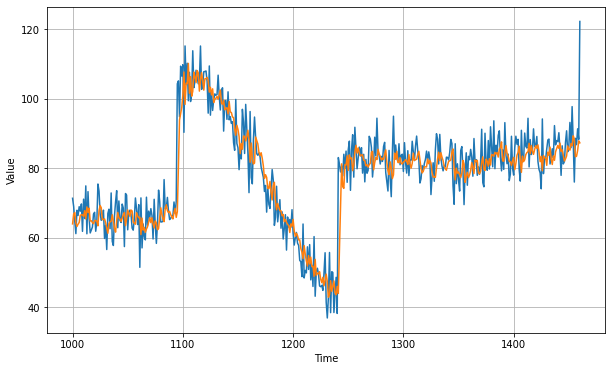

In [20]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model2.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [21]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.8174496

Observa los resultados e intenta comprender lo que ocurre y porque. : 
* ¿Que arquitectura ha dado mejor resultado? 
* ¿Cual tiene más parámetros a entrenar?
* ¿Porqué crees que ocurre?
* ¿Como crees que se puede mejorar?

Puedes consultar información al respecto aquí: 
https://datascience.stackexchange.com/questions/23029/why-are-rnn-lstm-preferred-in-time-series-analysis-and-not-other-nn

##Referencias

*   Documento inspirado en los ejemplos del repositorio de LaurenceMorone y en su curso de Deep Learning con TensorFlow: https://github.com/lmoroney?tab=repositories 
* Doc oficial Pytorch https://pytorch.org/docs/stable/generated/torch.nn.RNN.html
* https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html



## Fin del cuaderno